# Bayesian Logistic Regression Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report, f1_score
from imblearn.over_sampling import SMOTE
import pymc3 as pm
from scipy.stats import mode
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score

In [2]:
fraud = pd.read_csv('../data/creditcard.csv')

### Splitting my data into my X variables and Y which is the class column and creating a sample dataframe to train my data on. 

In [3]:
X_fraud = fraud.drop(columns=['Class'])
y_fraud = fraud['Class']

In [4]:
fraud_only = fraud[fraud["Class"] == 1]
non_fraud = fraud[fraud["Class"] == 0].sample(n=10_000)

In [5]:
sample_fraud = pd.concat([fraud_only, non_fraud])
X_30 = sample_fraud.drop(columns=['Class'])
y_30 = sample_fraud['Class']
X_30.reset_index(inplace=True)


#### Using SMOTE to oversample my minority class(Fraud) and undersample my minority class(not fraud).

In [6]:
sm_30 = SMOTE(sampling_strategy= 1, kind ='regular', random_state=2019)
sample_X, sample_y = sm_30.fit_sample(X_30, y_30.ravel())

In [7]:
sample_X_df = pd.DataFrame(sample_X)
sample_X_df.drop(columns=[0], inplace=True)
ss = StandardScaler()
sample_X_df = pd.DataFrame(ss.fit_transform(sample_X_df))
sample_X_df.columns = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
sample_X_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.814230,0.029220,0.020265,0.329028,0.538436,0.263588,-0.419814,0.058993,0.220652,-0.657480,...,-0.064789,0.039982,-0.011940,-0.432335,0.688679,0.020338,0.336669,0.175116,-0.456582,-0.451456
1,-1.812863,-0.105433,-1.382088,0.770607,-0.007514,0.718974,-0.208576,0.566418,-0.079100,0.472321,...,1.858830,0.092099,0.400016,1.312665,-0.446713,0.400432,-0.386272,-0.371719,-0.023147,1.904351
2,-1.730206,0.030855,-0.032638,0.533608,0.005773,0.191133,0.368997,0.608378,-0.147156,0.487103,...,-0.607115,-0.252745,-0.797582,0.172279,-0.064909,-0.303787,-1.274882,-0.060656,-0.480193,0.617029
3,-1.677919,-0.354819,-0.142668,0.168161,0.117420,0.116968,-0.583322,-0.110945,-0.116272,0.482802,...,-0.355478,0.060308,0.173685,-0.404846,-0.002355,0.356179,-1.531802,-0.982871,1.946991,-0.188710
4,-1.666877,0.682215,0.313330,-0.111968,0.773165,1.266890,-0.379636,0.812401,-0.167122,0.014862,...,-0.179548,-0.283374,-0.597780,-0.613920,-2.922471,2.353744,1.206694,-0.113414,0.245640,-0.447003


In [8]:
sample_y_df =pd.DataFrame(sample_y, index=sample_X_df.index)
sample_y_df.rename(columns={0: 'Class'}, inplace=True)

In [9]:
sample_df = sample_X_df.join(sample_y_df)

### Use PyMC to create the distributions for my Logistic Regression.

In [10]:
#Used the following links below for assistance in creating the model.
#https://discourse.pymc.io/t/bad-initial-energy-inf-the-model-might-be-misspecified/1431/6
#https://docs.pymc.io/notebooks/GLM-logistic.html
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('Class ~ Amount + Time + V1 + V2', sample_df, family=pm.glm.families.Binomial())
    trace_logistic_model = trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [V2, V1, Time, Amount, Intercept]
Sampling 4 chains: 100%|██████████| 8000/8000 [07:20<00:00, 18.17draws/s] 


### Plotting the Distributions for each of my variables.

<Figure size 1080x720 with 0 Axes>

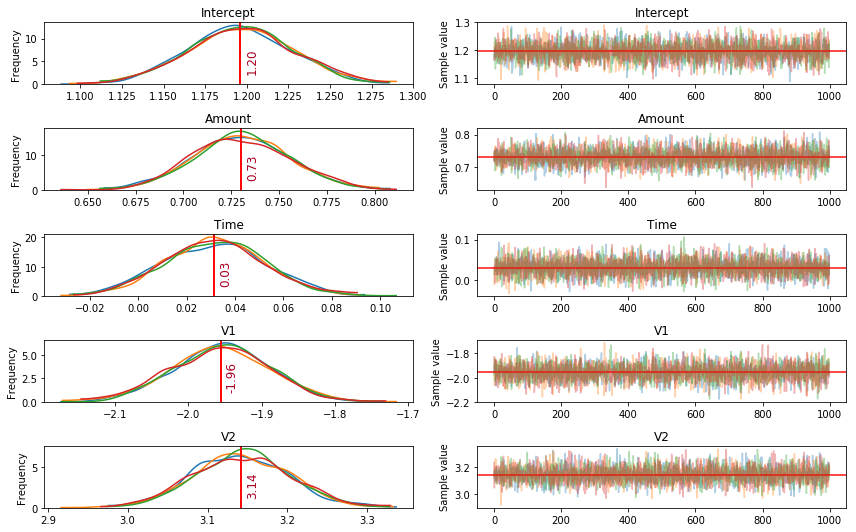

In [11]:
#Used the link below in assistance in creating the plots.
#https://docs.pymc.io/notebooks/GLM-logistic.html
plt.figure(figsize=(15, 10))
    
ax = pm.traceplot(trace_logistic_model[-1000:], figsize=(12,len(trace_logistic_model.varnames)*1.5),
    lines={k: v['mean'] for k, v in pm.summary(trace_logistic_model[-1000:]).iterrows()})

for i, mn in enumerate(pm.summary(trace_logistic_model[-1000:])['mean']):
    ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')


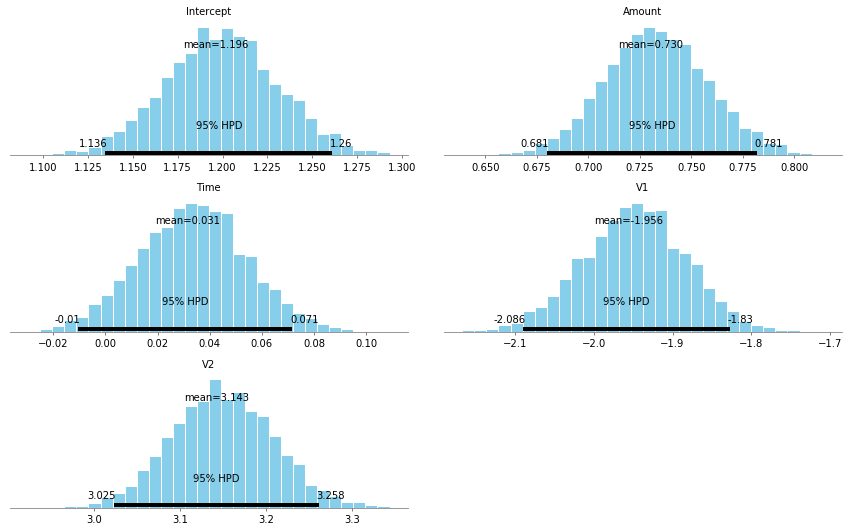

In [12]:
pm.posteriorplot.plot_posterior(trace_logistic_model);

### Create a Logistic Regression for the first Coefficients and view the ROC AUC Curve

[[8942 1058]
 [2080 7920]]
   Model  Actual
0    1.0     1.0
1    0.0     1.0
2    1.0     1.0
3    1.0     1.0
4    1.0     1.0
0.8431
0.792


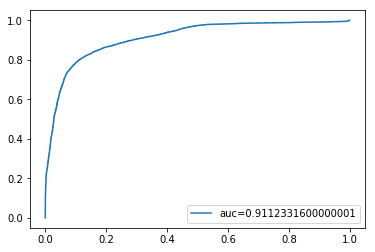

In [13]:
inter_bayes = trace_logistic_model['Intercept']
amount_bayes = trace_logistic_model['Amount']
time_bayes = trace_logistic_model['Time']
v1_bayes = trace_logistic_model['V1']
v2_bayes = trace_logistic_model['V2']
bayes_dict = {'Intercept': inter_bayes, 'Amount': amount_bayes, 'Time': time_bayes, 'V1': v1_bayes, 'V2': v2_bayes}
bayes_coefs = pd.DataFrame(bayes_dict)

prob_1 = 1 / (1 + np.exp(-(bayes_coefs['Intercept'][0] + bayes_coefs['Amount'][0] * sample_df['Amount'] +
                 bayes_coefs['Time'][0] * sample_df['Time'] + bayes_coefs['V1'][0] * sample_df['V1'] + 
                 bayes_coefs['V2'][0] * sample_df['V2'])))
prob_1_round = prob_1.round(0)
prob_1_round = pd.DataFrame([prob_1_round.values.tolist(), sample_df['Class'].values.tolist()]).T
prob_1 = pd.DataFrame([prob_1.values.tolist(), sample_df['Class'].values.tolist()]).T
prob_1_round.columns = ['Model', 'Actual']
prob_1.columns = ['Model', 'Actual']
print(confusion_matrix(prob_1_round['Actual'], prob_1_round['Model']))
print(prob_1_round.head())
print(accuracy_score(prob_1_round['Actual'], prob_1_round['Model']))
print(recall_score(prob_1_round['Actual'], prob_1_round['Model']))

#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, _ = roc_curve(prob_1['Actual'],  prob_1['Model'])
auc = roc_auc_score(prob_1['Actual'], prob_1['Model'])
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [14]:
empty_list = []
for i in range(2_000):
    prob = 1 / (1 + np.exp(-(bayes_coefs['Intercept'][i] + bayes_coefs['Amount'][i] * sample_df['Amount'] +
                 bayes_coefs['Time'][i] * sample_df['Time'] + bayes_coefs['V1'][i] * sample_df['V1'] + 
                 bayes_coefs['V2'][i] * sample_df['V2'])))
    prob = prob.round(0)
    prob = pd.DataFrame([prob.values.tolist(), sample_df['Class'].values.tolist()]).T
    prob.columns = ['Model', 'Actual']
    #print(confusion_matrix(prob_1['Actual'], prob_1['Model']))
    empty_list.append(recall_score(prob['Actual'], prob['Model']))

/anaconda3/envs/DSI/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


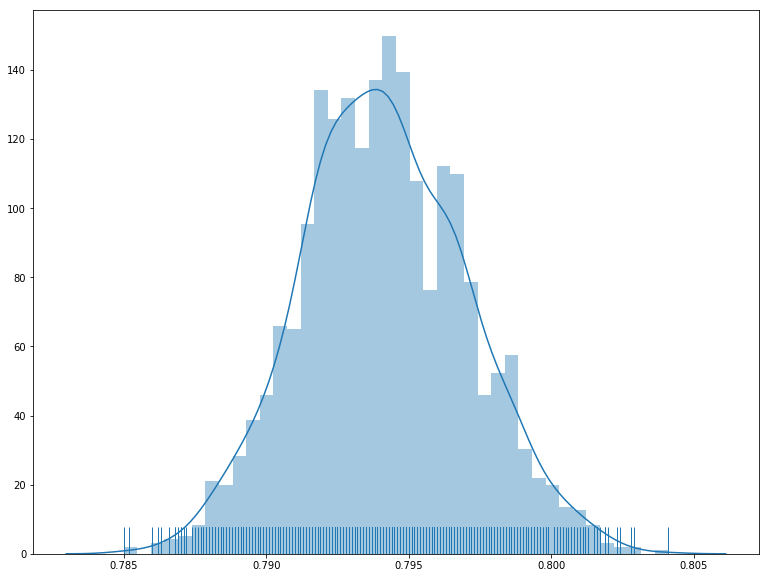

In [15]:
plt.figure(figsize=(13, 10))
sns.distplot(empty_list, rug=True, bins=40)